In [31]:
from numpy.linalg import inv

class Kalman():
    '''Implements a 1D (observation dimension) Bayesian Kalman filter following the probabilistic approach of Murphy page ~641.  
       dim_z is the number of measurement inputs
    
    Attributes
    ----------
    mu : numpy.array(dim_mu, 1)
        State estimate vector
        
    sigma : numpy.array(dim_x, dim_x)
        Covariance matrix
    
    A : numpy.array(dim_mu, dim_mu)
        State Transition matrix
    
    B : numpy.array(dim_mu, dim_u)
        Control transition matrix
    
    C : numpy.array(dim_mu, dim_mu)
        Measurement function
    
    D : numpy.array(dim_mu, dim_u)
        Control observation matrix
    
    R : numpy.array(dim_z, dim_z)
        Measurement noise matrix
        
    Q : numpy.array(dim_x, dim_x)
        Process noise matrix
        
    S : numpy.array(dim_z, dim_z)
        Observation Noise Estimate. For now set to R 
        
    '''
    
    def __init__(self, mu_0, sigma_0, A, B, C, D, Q, R):
        '''
        Parameters
        ----------
        mu_0 : numpy.array(dim_mu, 1)
            Initial state estimate vector

        sigma_0 : numpy.array(dim_x, dim_x)
            Initial covariance matrix

        A : numpy.array(dim_mu, dim_mu)
            State Transition matrix

        B : numpy.array(dim_mu, dim_u)
            Control transition matrix

        C : numpy.array(dim_mu, dim_mu)
            Measurement function

        D : numpy.array(dim_mu, dim_u)
            Control observation matrix

        R : numpy.array(dim_z, dim_z)
            Measurement noise matrix

        Q : numpy.array(dim_x, dim_x)
            Process noise matrix
        '''
        self.A = A   # Parameter matrix A 
        self.B = B   # Parameter matrix B 
        self.C = C   # Parameter matrix C 
        self.D = D   # Parameter matrix D
        self.Q = Q   # State noise covaraiance matrix 
        self.R = R   # Observation noise covariance matrix
        self.S = self.R # Observation Noise Estimate. For now set to R 
        self.mu = mu_0 # Initial state estimate 
        self.sigma = sigma_0 # Initial state covariance 
        
        
    def predict(self, u=None): 
        ''' Murphy Sec. 18.3.1.1'''
        
        # Predicted state covariance 
        self.sigma = np.dot(np.dot(self.A, self.sigma), self.A.T) + self.Q
        
        # if there is no control input do not include it 
        if u is None:
            self.mu = np.dot(self.A, self.mu)  # Predict state mean 
        else:
            self.mu = np.dot(self.A, self.mu) + np.dot(self.B, self.u)

    
        
    def update(self, Y):
        '''
        Add a new measurement (z) to the Kalman filter. If z is None, nothing
        is changed.  Murphy Sec. 18.3.1.2
        
        Parameters
        ----------
        Y : np.array(dim_z)
            measurement for this update. z can be a scalar if dim_z is 1,
            otherwise it must be a column vector.

        '''
        
        self.y = np.dot(self.C,self.mu) # Posterior predictive mean 
        
        r = Y - self.y # residual 
        S = np.dot(np.dot(self.C, self.sigma), self.C.T) + self.R #         
        K = np.dot(np.dot(self.sigma, self.C.T), inv(S)) # Kalman Gain 
        
        # Correct the state covariance and mean 
        self.mu = self.mu + np.dot(K, r)
        I_KC = np.identity(len(self.mu)) - np.dot(K,self.C)
        self.sigma = np.dot(np.dot(I_KC, self.sigma), I_KC.T) + np.dot(np.dot(K,self.R), K.T)
        
        # Update the class attribute values 
        self.K = K 
        self.S = S 
        
        
        

In [153]:
import pandas as pd
import time 

def FilterSnowdepth(sensor_number, obs_noise, system_noise, outlier_threhold=2e3):
    '''
    Run a forward Kalman filter through a single snowdepth sensor time series.
    
    Parameters
    ----------
    sensor_number : integer
        integer index of sensor in pandas dataframe.  
    obs_noise : np.array(z_dim, z_dim)
        Specify the observation noise covariance matrix.  Scalar if z_dim=1 (observation dimension)
    
    system_noise : np.array(mu_dim, mu_dim)
        Specifies the system (process) covariance matrix mu_dim is the state dimension
        
    outlier_threshold : float
        Distance threshold in mm before point is considered an outlier, and thus not used in 
        the measurement update.  This needs to be large enough that real baseline shifts are not omitted.
    
    Returns 
    ----------
    mu_list : np.array(N_obs, dim_mu)
        contains the updated state vector for each observation
    
    sigma_list : contains the projected measurement covariance at each observation. 
    
    '''
    
    df = pd.read_pickle('../output/cluster_0_cleaned.pickle')
    # Observations 
    Y = df['snowdepth_%i'%sensor_number].values
    
    # Let's estimate the initial baseline using the median of the first 2500 data points, excluding NaNs
    baseline = np.median(Y[:2500][~np.isnan(Y[:2500])])

    # Label the state parameters. 
    state_params=['depth_1', 'velocity_1', 'baseline_1']
    
    # First observation that is not nan 
    Y0 = Y[np.argwhere(~np.isnan(Y))[0]]
    sigma_0 = np.diag((50, 10, 10))
    mu_0 = np.array([-Y0+baseline, 0., baseline]) # Initial state is the first observation 
    dt = .25 # 15 minute intervals.  Velocity in mm/hr
    
    # Transition Matrix 
    A = np.array([[1, dt, 0],
                  [0,  1, 0],
                  [0,  0, 1]])

    # Control Model 
    B = np.zeros((len(mu_0),len(mu_0)))

    # Observation Matrix
    C = np.array([[-1, 0, +1],]) 

    # Process noise.
    Q = system_noise
    
    # Observation Noise
    R = obs_noise

    # For now, no control input 
    u = None
    D = None 

    K = Kalman(state_params, Y, mu_0, sigma_0, dt, A, B, C, D, Q, R)

    sigma_list  = np.zeros(len(Y)) 
    mu_list = np.zeros((len(Y),len(mu_0)))
    #diffs = np.zeros(len(Y)) # Debugging 
    
    # Initial values
    mu_list[0,:] = mu_0
    sigma_list[0] = obs_noise
    
    print 'Processing sensor %i'%sensor_number
    start = time.time()
    for i_obs in range(1, len(Y)):
        K.predict()
        
        # Only update the state if we have a valid measurement 
        # and it is not an obvious outlier (threhold is a change of >2meters)
        
        difference = np.abs((Y[i_obs]-np.dot(K.C,K.mu)))
        # diffs[i_obs] = difference # Debugging 
        if not np.isnan(Y[i_obs]) and (difference < 2e3):
            K.update(Y[i_obs])
        
        mu_list[i_obs] = K.mu
        sigma_list[i_obs] = K.S
                
        if (i_obs%500)==0:
            print '\r Forward pass on observation %i of %i'%(i_obs,len(Y)), 
    
    print '\n Completed Forward Pass in %1.2f s'%(time.time()-start)
    return mu_list, sigma_list

In [158]:
results = [FilterSnowdepth(i, obs_noise=25**2., system_noise=np.diag((1e-3,1e-3,1e-3)))
           for i in range(1,10)]


Processing sensor 1
 Forward pass on observation 17500 of 17569 
 Completed Forward Pass in 2.35 s
Processing sensor 2
 Forward pass on observation 17500 of 17569 
 Completed Forward Pass in 1.35 s
Processing sensor 3
 Forward pass on observation 17500 of 17569 
 Completed Forward Pass in 2.24 s
Processing sensor 4
 Forward pass on observation 17500 of 17569 
 Completed Forward Pass in 1.79 s
Processing sensor 5
 Forward pass on observation 17500 of 17569 
 Completed Forward Pass in 2.08 s
Processing sensor 6
 Forward pass on observation 17500 of 17569 
 Completed Forward Pass in 1.96 s
Processing sensor 7
 Forward pass on observation 17500 of 17569 
 Completed Forward Pass in 2.18 s
Processing sensor 8
 Forward pass on observation 17500 of 17569 
 Completed Forward Pass in 1.98 s
Processing sensor 9
 Forward pass on observation 17500 of 17569 
 Completed Forward Pass in 1.96 s


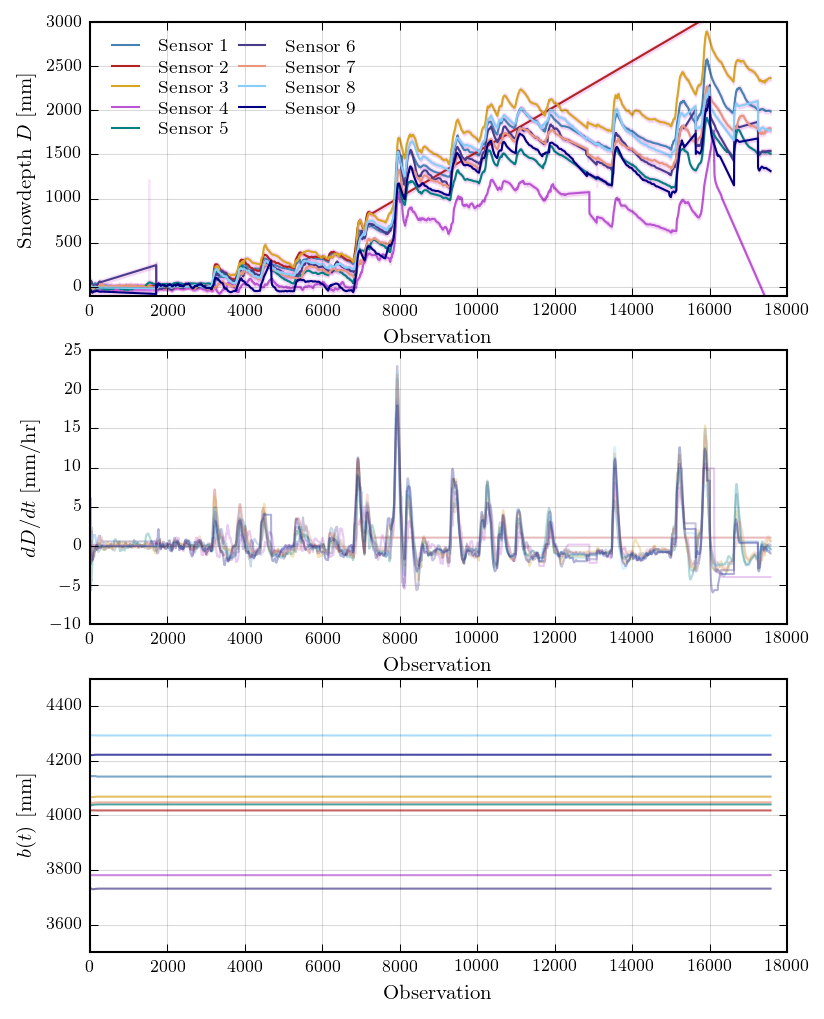

In [159]:

plt.figure(figsize=(6,8))
for i_sensor, (mu, sigma, diffs) in enumerate(results[:11]):
    
    # This sensor went out after not very long
#     if i_sensor==1: 
#         continue
    
    # Load the observations for plotting 
    df = pd.read_pickle('../output/cluster_0_cleaned.pickle')
    Y = df['snowdepth_%i'%(i_sensor+1)].values
    
    plt.subplot(311)
    # Plot the snowdepth 
    plt.plot(mu[:,0], label='Sensor %i'%(i_sensor+1))
    plt.xlabel('Observation')
    plt.ylabel('Snowdepth $D$ [mm]')
    plt.grid(linestyle='-', alpha=.15)
    plt.legend(loc=2, ncol=2, frameon=False, columnspacing=.2, labelspacing=.2)
    plt.ylim(-100, 3000)

    # Can also plot uncertainty bands, though these are not great yet.
    plt.fill_between(range(len(mu[:,0])), mu[:,0]-np.sqrt(sigma), mu[:,0]+np.sqrt(sigma), alpha=.1, color='m')
    
    
    # -------------------------------
    # Plot the velocity parameter
    plt.subplot(312)
    plt.plot(mu[:,1], alpha=.3)
    plt.xlabel('Observation')
    plt.ylabel('$dD/dt$ [mm/hr]')
    plt.ylim(-10,25)
    plt.grid(linestyle='-', alpha=.15)
        
    # -------------------------------
    # Plot the baseline
    plt.subplot(313)
    plt.plot(mu[:,2], alpha=.7)
    plt.xlabel('Observation')
    plt.ylabel('$b(t)$ [mm]')
    plt.ylim(3.5e3,4.5e3)
    plt.grid(linestyle='-', alpha=.15)


